# Practice Session 05: PageRank

<font size="+2" color="blue">Additional results: spam/nonspam visualization</font>

# 1. Read host names

In [42]:
import io
import gzip
import csv
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
INPUT_NODES_FILENAME = "webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "webspam_uk2007-edges.csv.gz"

In [3]:
id2name = {}
name2id = {}
id2label = {}

with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        id2name[int(record['nodeid'])] = record['hostname']
        name2id[record['hostname']] = int(record['nodeid'])
        id2label[int(record['nodeid'])] = record['label']

In [4]:
# Leave as-is

print("Number of hosts: %s" % len(id2name))
print("%s: %s" % (id2name[873], id2label[873]))
print("%s: %s" % (id2name[105715], id2label[105715]))

Number of hosts: 114529
bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam


In [5]:
spam=0
nonspam=0
unlabeled=0

for host in id2name:
    if id2label[host]=='spam':
        spam+=1
    elif id2label[host]=='nonspam':
        nonspam+=1
    else:
        unlabeled+=1

total = spam + nonspam + unlabeled

print(f"spam: {spam:,} ({(spam / total) * 100:.1f}%)")
print(f"nonspam: {nonspam:,} ({(nonspam / total) * 100:.1f}%)")
print(f"unlabeled: {unlabeled:,} ({(unlabeled / total) * 100:.1f}%)")

spam: 344 (0.3%)
nonspam: 5,709 (5.0%)
unlabeled: 108,476 (94.7%)


In [6]:
spammywords = ['credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury', 'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort', 'xx', 'girl', 'mistress', 'important', 'attention']
g = nx.DiGraph()

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        for keyword in spammywords:
            if keyword in id2name[int(record['source'])] or keyword in id2name[int(record['destination'])]:
                if(id2label[int(record['source'])] =='spam'or id2label[int(record['source'])] == 'nonspam'):
                    if(id2label[int(record['destination'])] =='spam'or id2label[int(record['destination'])] == 'nonspam'):
                        g.add_edge(id2name[int(record['source'])],id2name[int(record['destination'])])

print(g.number_of_nodes())

172


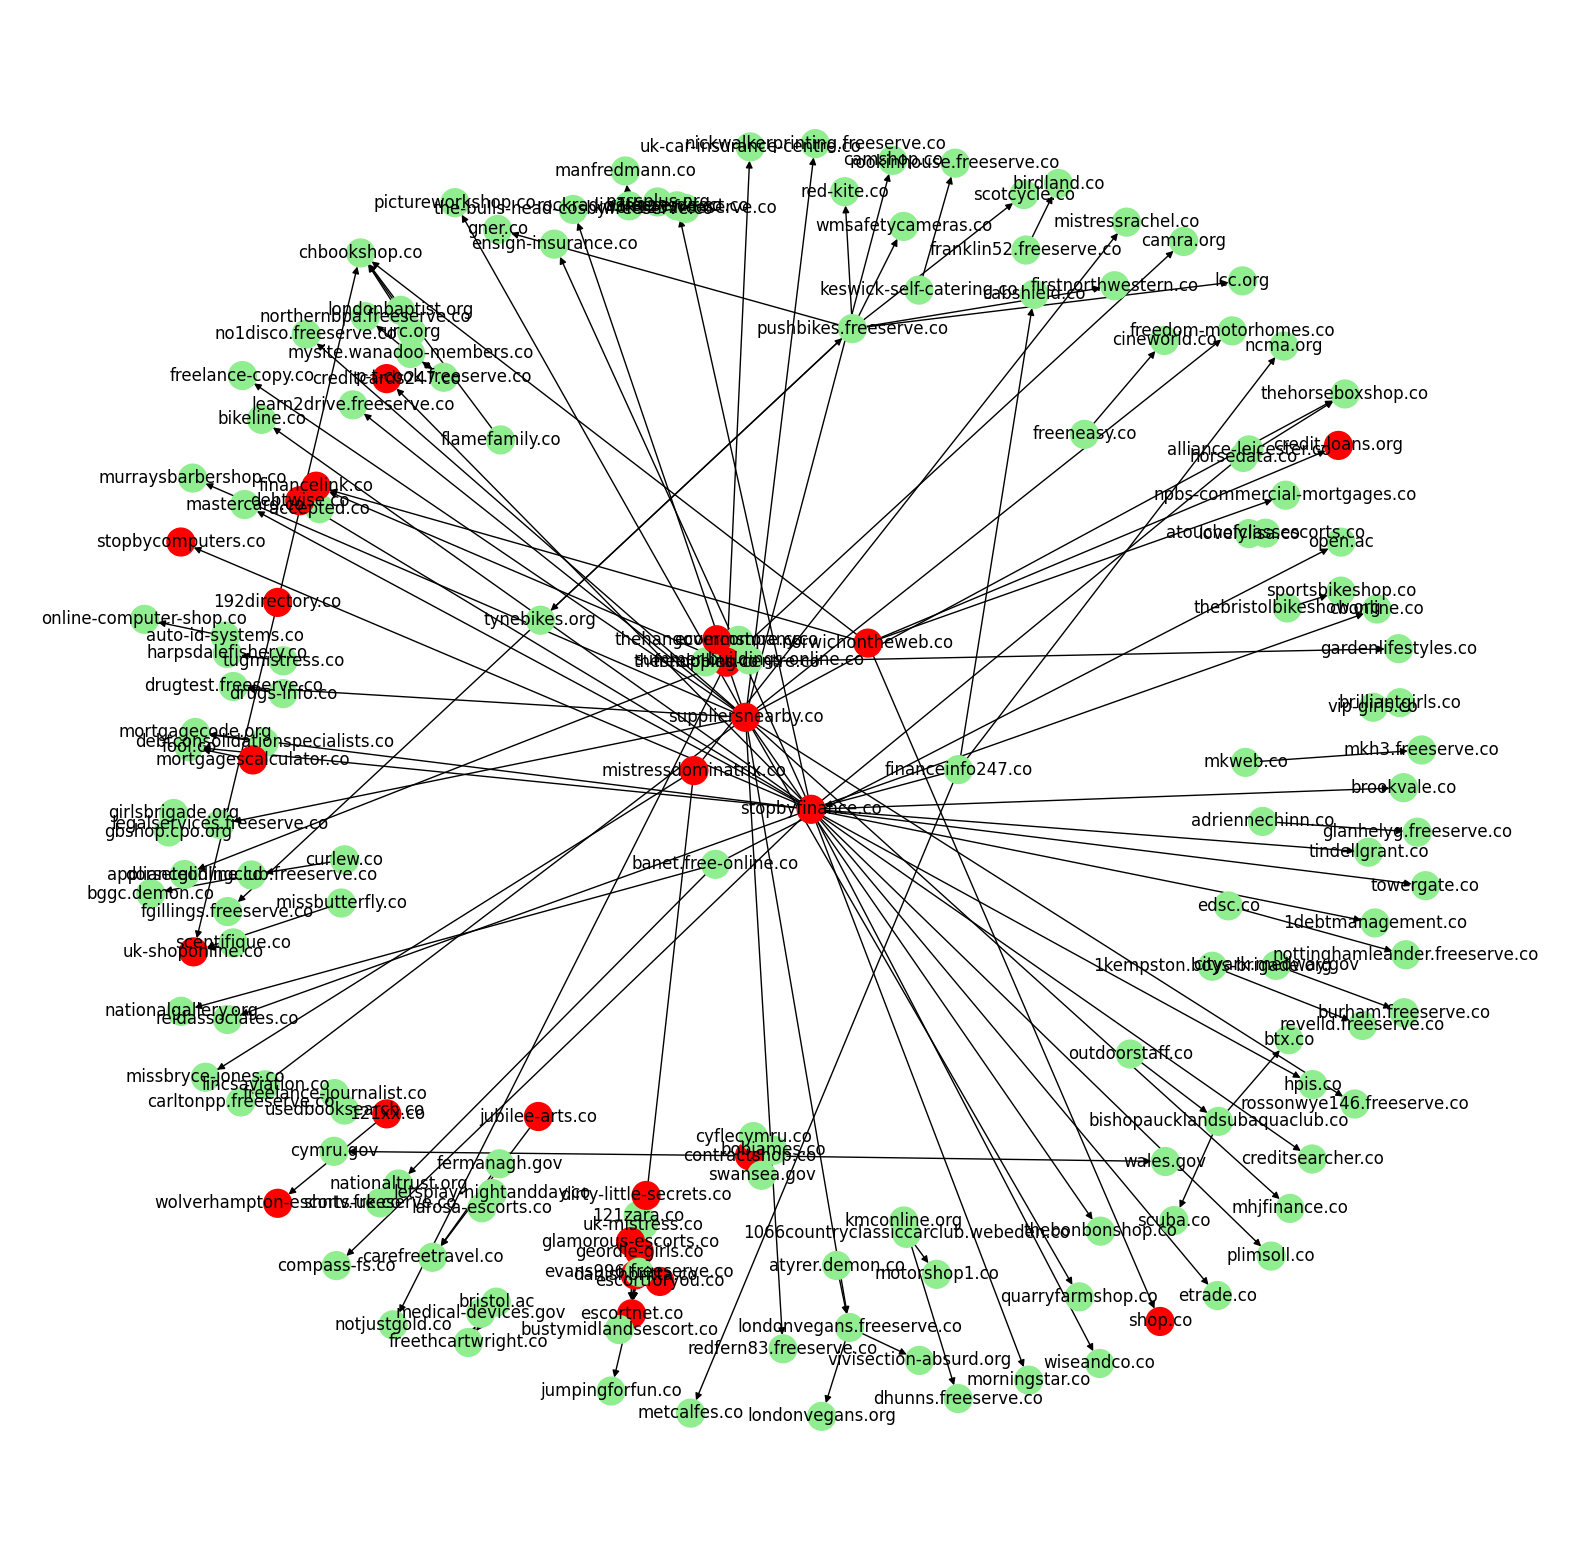

In [7]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if id2label[name2id[hostname]] == 'spam':
        colors.append('red')
    elif id2label[name2id[hostname]] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')

    # Shorten the hostnames to generate labels
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label

# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

**<font color='red'>The graph shows a star-like structure with central hubs like stopbyfinance.co, freelollies.com, or ecommstore.co, which reference many peripheral websites. These hubs controll the link activity, while the peripheral sites are less connected. This pattern suggests a hub-and-spoke network, which is quite common in web spam behavior, where a few central sites link to many less authoritative ones to manipulate rankings.**

# 2. Compute the degree of each node

In [8]:
# Leave this code as-is

id2degree = {}
N = len(id2name)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [9]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        id2degree[int(record['source'])] += 1

In [10]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print("%s: degree %d" % (id2name[nodeid], id2degree[nodeid]))

www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38


# 3. Compute PageRank

In [11]:
# Leave this cell as-is

ITERATIONS = 25
ALPHA = 0.91

pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N

In [14]:
sum = 1
for iteration in range(ITERATIONS):

    print("Iteration %d of %d" % (iteration+1, ITERATIONS))
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
        for record in reader:
            pagerank_aux[int(record['destination'])]+= pagerank[int(record['source'])]/id2degree[int(record['source'])]

        delta = sum
        sum = 0

        for i in range(N):
            pagerank[i] = (ALPHA * pagerank_aux[i]) + ((0.1)*(1.0/N))
            sum += pagerank[i]

        for i in range(N):
            pagerank[i] = pagerank[i]/sum

        delta -=  sum
        print(abs(delta),'\n------------------')
        pagerank_aux = [0.0]*N

Iteration 1 of 25
0.33457231318723 
------------------
Iteration 2 of 25
0.43987817456957645 
------------------
Iteration 3 of 25
0.007943233574339015 
------------------
Iteration 4 of 25
0.0004173392452010427 
------------------
Iteration 5 of 25
0.0004494750436891959 
------------------
Iteration 6 of 25
0.0006204559904479101 
------------------
Iteration 7 of 25
0.0005376755105738207 
------------------
Iteration 8 of 25
0.0004906264715275332 
------------------
Iteration 9 of 25
0.000458338885899523 
------------------
Iteration 10 of 25
0.0004238400477863946 
------------------
Iteration 11 of 25
0.0004073911128794627 
------------------
Iteration 12 of 25
0.0003884976577440691 
------------------
Iteration 13 of 25
0.0003830349399214228 
------------------
Iteration 14 of 25
0.00037068278886809303 
------------------
Iteration 15 of 25
0.00037010347641508456 
------------------
Iteration 16 of 25
0.0003628078267106094 
------------------
Iteration 17 of 25
0.0003633426933706829

# 4. Nodes with largest values of PageRank

In [15]:
NUM_HOSTS = 20
NUM_DECIMALS = 6

def largest_pagerank(pagerank):
    hosts_by_score = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)

    for i in range(NUM_HOSTS):
        host_id = hosts_by_score[i][0]
        host_name= id2name[host_id]
        label = id2label[host_id]
        score = hosts_by_score[i][1]
        score = round(score,NUM_DECIMALS)

        print(host_id, host_name, label, score)

largest_pagerank(pagerank)

81634 www.opsi.gov.uk unlabeled 0.006095
65466 www.kelkoo.co.uk unlabeled 0.004281
9215 www.aa-roundabout.org.uk unlabeled 0.004083
12326 www.alcoholics-anonymous.org.uk unlabeled 0.003851
6475 shopping.kelkoo.co.uk unlabeled 0.003688
60715 www.ico.gov.uk unlabeled 0.003684
10990 www.adobe.co.uk unlabeled 0.003289
42757 www.dti.gov.uk unlabeled 0.002955
39774 www.defra.gov.uk unlabeled 0.002854
40999 www.direct.gov.uk unlabeled 0.002462
34406 www.communities.gov.uk unlabeled 0.002445
40559 www.dfes.gov.uk unlabeled 0.002343
40612 www.dh.gov.uk unlabeled 0.002001
751 audiovisual.kelkoo.co.uk unlabeled 0.00195
5169 news.bbc.co.uk unlabeled 0.001921
58631 www.hmso.gov.uk unlabeled 0.001885
51107 www.fsa.gov.uk unlabeled 0.00187
77619 www.nationalrail.co.uk unlabeled 0.001825
29600 www.cch.co.uk unlabeled 0.001779
37012 www.croner.co.uk unlabeled 0.001777


**<font color = 'red'> (1) The top sites seem to be mostly official government websites and a few large commercial domains. This is likely because of these sites have a large inbound links and their content is seen as trustworthy and because of general popularity for site like kelkoo or adobe which are very widely used**

**<font color = 'red'> (2) We can see that 50% of the sites are from the government, 40% are commercial, 10% are of the type .org which are typically non-profit organizations and no educational sites.**

# 5. Run non-spam PageRank

In [20]:
id2nsdegree = {}

N = len(id2name)
for nodeid in range(N):
    id2nsdegree[nodeid] = 0

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        if (id2label[int(record['source'])] != "spam" and id2label[int(record['destination'])] != "spam"):
            id2nsdegree[int(record['source'])] += 1

In [26]:
# this is not asked for, but the IDs provided in the code below don't correspond to the ones that are asked for in the statement

def find_id(host_name, id2name):
    for nodeid, name in id2name.items():
        if name == host_name:
            return nodeid
    return None

websites = ['www.ucl.ac.uk', 'candycaine.skinthesun.co.uk', 'www.financelink.co.uk']

for website in websites:
    nodeid = find_id(website, id2name)
    if nodeid is not None:
        print("%s: normal degree %d nospam degree %d" % (id2name[nodeid], id2degree[nodeid], id2nsdegree[nodeid]))

www.ucl.ac.uk: normal degree 1378 nospam degree 1378
candycaine.skinthesun.co.uk: normal degree 22 nospam degree 20
www.financelink.co.uk: normal degree 5 nospam degree 0


In [27]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print("%s: normal degree %d nospam degree %d" % (id2name[nodeid], id2degree[nodeid], id2nsdegree[nodeid]))

www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37


In [30]:
# This is provided in the notebook

ITERATIONS = 25
ALPHA = 0.90

nspagerank = [1.0/N] * N
nspagerank_aux = [0.0] * N

In [31]:
sum = 1
for iteration in range(ITERATIONS):
    print("Iteration %d of %d" % (iteration+1, ITERATIONS))
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
        for record in reader:
            if (id2label[int(record['source'])] != "spam" and id2label[int(record['destination'])] != "spam"):
                nspagerank_aux[int(record['destination'])]+= nspagerank[int(record['source'])]/id2nsdegree[int(record['source'])]

        delta = sum
        sum = 0

        for i in range(N):
            nspagerank[i] = (ALPHA * nspagerank_aux[i]) + ((0.1)*(1.0/N))
            sum += nspagerank[i]

        for i in range(N):
            nspagerank[i] = nspagerank[i]/sum

        delta -=  sum
        print(abs(delta),'\n------------------')
        nspagerank_aux = [0.0]*N

Iteration 1 of 25
0.3894559456556268 
------------------
Iteration 2 of 25
0.21414919269416088 
------------------
Iteration 3 of 25
0.021170493568277382 
------------------
Iteration 4 of 25
0.016961597657093486 
------------------
Iteration 5 of 25
0.004396376143373959 
------------------
Iteration 6 of 25
0.004428618759001801 
------------------
Iteration 7 of 25
0.001737330943260229 
------------------
Iteration 8 of 25
0.0018672731445672497 
------------------
Iteration 9 of 25
0.0009455052418776422 
------------------
Iteration 10 of 25
0.001002428632114416 
------------------
Iteration 11 of 25
0.0006231974025068254 
------------------
Iteration 12 of 25
0.0006574531821155194 
------------------
Iteration 13 of 25
0.00047877223257586365 
------------------
Iteration 14 of 25
0.0005055470970084519 
------------------
Iteration 15 of 25
0.0004147697034437847 
------------------
Iteration 16 of 25
0.00043352886080583186 
------------------
Iteration 17 of 25
0.00038595243361694287 

In [32]:
largest_pagerank(nspagerank)

81634 www.opsi.gov.uk unlabeled 0.006383
60715 www.ico.gov.uk unlabeled 0.003762
10990 www.adobe.co.uk unlabeled 0.003419
65466 www.kelkoo.co.uk unlabeled 0.003088
42757 www.dti.gov.uk unlabeled 0.003086
39774 www.defra.gov.uk unlabeled 0.002979
12326 www.alcoholics-anonymous.org.uk unlabeled 0.002784
6475 shopping.kelkoo.co.uk unlabeled 0.002619
40999 www.direct.gov.uk unlabeled 0.002571
34406 www.communities.gov.uk unlabeled 0.002558
9215 www.aa-roundabout.org.uk unlabeled 0.002545
40559 www.dfes.gov.uk unlabeled 0.002451
40612 www.dh.gov.uk unlabeled 0.002093
5169 news.bbc.co.uk unlabeled 0.001997
58631 www.hmso.gov.uk unlabeled 0.00197
51107 www.fsa.gov.uk unlabeled 0.001945
77619 www.nationalrail.co.uk unlabeled 0.001897
59140 www.homeoffice.gov.uk unlabeled 0.001776
59870 www.hse.gov.uk unlabeled 0.001722
43141 www.dwp.gov.uk unlabeled 0.001693


**<font color='red'>Overall, the changes between the regular and non-spam pagerank scores are relatively small for these top hosts, but the impact is stronger for commercial sites like Kelkoo. Because government websites tend to have a strong pagerank presence in both scenarios, as their links are more organic and less influenced by spamm.**

# 6. Compute spam gain

In [40]:
NUM_HOSTS = 50

def compute_gain_and_print(normal_pagerank, nspagerank, id2name, id2label):
    gains = []

    for host_id in range(len(normal_pagerank)):
        if nspagerank[host_id] > 0:
            gain = normal_pagerank[host_id] / nspagerank[host_id]
        else:
            gain = np.inf
        gains.append((host_id, gain, normal_pagerank[host_id], nspagerank[host_id]))

    gains.sort(key=lambda x: x[1], reverse=True)

    for i in range(min(NUM_HOSTS, len(gains))):
        host_id, gain, norm_pr, nspam_pr = gains[i]
        host_name = id2name[host_id]
        label = id2label[host_id]

        norm_pr_sci = f"{norm_pr:.2e}"
        nspam_pr_sci = f"{nspam_pr:.2e}"

        gain_formatted = f"{gain:.2f}"

        print(f"Site: {host_name}\nLabel: {label}\nGain: {gain_formatted}\nPageRank:{norm_pr_sci}\nNo-Spam PageRank: {nspam_pr_sci}\n----------------")

compute_gain_and_print(pagerank, nspagerank, id2name, id2label)

Site: baby.discover-shopping.co.uk
Label: unlabeled
Gain: 3.34
PageRank:2.94e-04
No-Spam PageRank: 8.81e-05
----------------
Site: www.1stopwebservices.co.uk
Label: unlabeled
Gain: 3.34
PageRank:2.73e-04
No-Spam PageRank: 8.17e-05
----------------
Site: www.agentfinance.co.uk
Label: unlabeled
Gain: 2.70
PageRank:2.40e-04
No-Spam PageRank: 8.90e-05
----------------
Site: www.askprocess.co.uk
Label: unlabeled
Gain: 2.65
PageRank:2.05e-04
No-Spam PageRank: 7.73e-05
----------------
Site: www.ashteadhomoeopathy.co.uk
Label: unlabeled
Gain: 2.64
PageRank:2.05e-04
No-Spam PageRank: 7.74e-05
----------------
Site: es.juno.co.uk
Label: unlabeled
Gain: 2.62
PageRank:9.57e-04
No-Spam PageRank: 3.65e-04
----------------
Site: trickeys.co.uk
Label: unlabeled
Gain: 2.52
PageRank:1.45e-04
No-Spam PageRank: 5.74e-05
----------------
Site: www.paulwhiteltd.co.uk
Label: nonspam
Gain: 2.52
PageRank:1.45e-04
No-Spam PageRank: 5.74e-05
----------------
Site: aecltd.impact-group.co.uk
Label: unlabeled
Gain

**<font color="red">We can find a couple of sites like baby.discover-shopping.co.uk that have very strong gain ratios which means that they have been winning a very strong pagerank score because of spam. We can also find some other sites that have a similar pagerank score but a very similar non-spam pagerank score which most likely means that they are legitimate. Now we can actually see a strong difference between the regular pagerank and the non-spam pagerank which is great to find sites that are used for spam, this is mainly because the non-spam pagerank not only looks at the quantity of links but also at the quality so to speak.**

In [65]:
# sample of 500 nodes
sample = [node for node in list(g.nodes)[:500] if id2label[name2id[node]] in ['spam', 'nonspam']]

subgraph = g.subgraph(sample).copy()
for node in subgraph.nodes():
    node_id = name2id[node]
    subgraph.nodes[node]['label'] = id2label[node_id]
    subgraph.nodes[node]['hostname'] = id2name[node_id]

nx.write_graphml(subgraph, "webspam-sample.graphml")

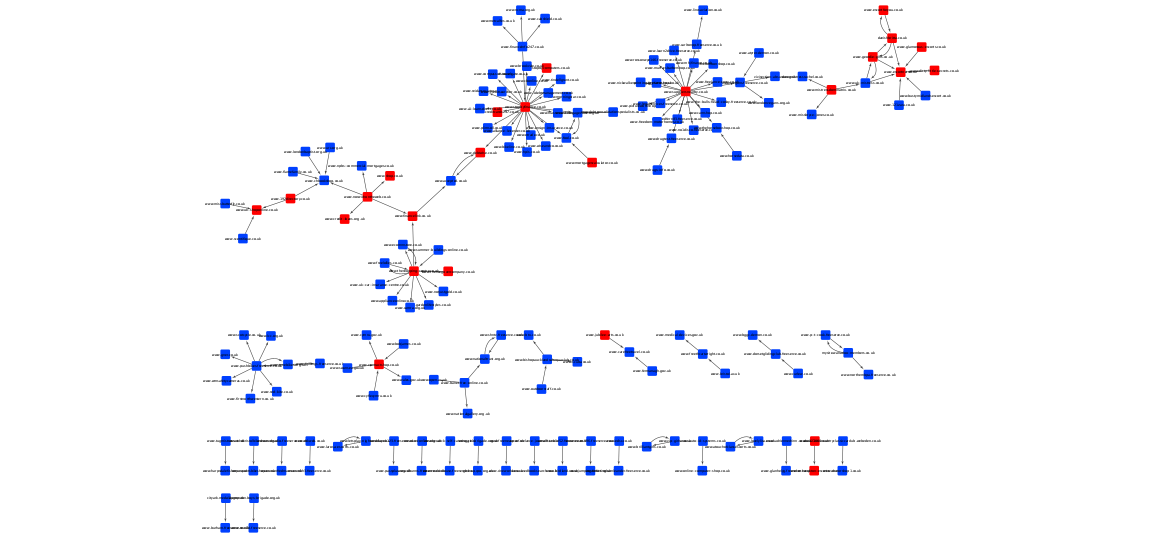

<font size="+2" color="red">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>